In [3]:
import json
import os
import csv
import urllib
from io import BytesIO
from PIL import Image
from itertools import product
from collections import namedtuple
from socket import timeout
import torch
from torchvision import models, utils, transforms
from torch.utils.data import Dataset, SubsetRandomSampler, SequentialSampler, Sampler
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from dataset import Fruits, SubsetSampler
from utils import visualize_samples, imshow
from training import train_model, compute_accuracy

%matplotlib inline
device = torch.device("cuda:0")

In [1]:
import numpy as np

In [17]:
a = np.array([[2,3], [4,5]])
print(a.shape)

(2, 2)


Lets prepere images for loading.

In [ ]:
!unzip 'train_images.zip'
train_folder = "train_images/"
print('Number of files in the train folder', len(os.listdir(train_folder)))

Creating datasets which will be used in training. Augmentation modes are random raotation and colorjitter.

In [5]:
orig_dataset = Fruits(train_folder, 
                      transform = transforms.Compose([
                          transforms.RandomRotation(60),
                          transforms.ColorJitter(brightness=0.1, 
                                                 contrast=0.1, 
                                                 saturation=0.1, 
                                                 hue=0.1)])
                     )
train_dataset = Fruits(train_folder, 
                       transform=transforms.Compose([
                           transforms.RandomRotation(60),
                           transforms.ColorJitter(brightness=0.1, 
                                                  contrast=0.1, 
                                                  saturation=0.1, 
                                                  hue=0.1),
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ]), production = False
                      )

Lets take a look at random 7 images after augmentation wiht class.

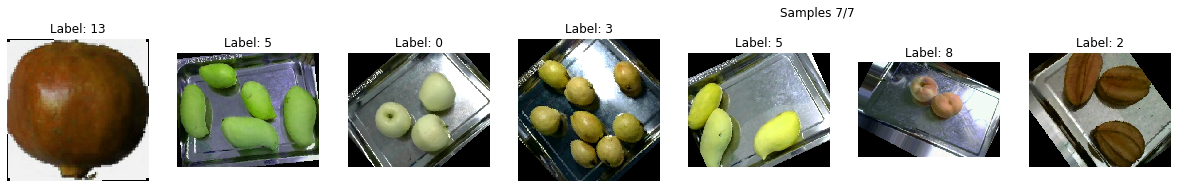

In [6]:
indices = np.random.choice(np.arange(len(orig_dataset)), 7, replace=False)
visualize_samples(orig_dataset, indices, 'Samples')

Preparation data for loading. All data was devided into train & val (70%) and test loaders (30 %).
Validation accuracy score was used for parameters searching.

In [7]:
batch_size = 8

data_size = len(train_dataset)
validation_fraction = .2
test_fraction = 0.3

test_split = int(np.floor((test_fraction) * data_size))
val_split = int(np.floor((validation_fraction) * (data_size - test_split)))

ind = list(range(data_size))
np.random.seed(42)
np.random.shuffle(ind)

val_ind, train_ind, test_ind = ind[:val_split], ind[val_split: -test_split], ind[-test_split:]

train_sampler = SubsetRandomSampler(train_ind)
val_sampler = SubsetRandomSampler(val_ind)
test_sampler = SubsetSampler(test_ind)
all_sampler = SubsetRandomSampler(ind)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         sampler=test_sampler)

all_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           sampler=all_sampler)

In [20]:
lr_base_params_list = [1e-4, 1e-5, 1e-6]   # List with learning rates for base layers.
lr_fc_params_list = [1e-2, 1e-3, 1e-4] # List with learning rates for fully connected layer.

Hyperparams = namedtuple(
    "Hyperparams", 
    ['learning_rate_base_param', 'learning_rate_fc']
)  # For writing of hyperparameters of every train running.
RunResult = namedtuple(
    "RunResult", 
    ['model', 'train_history', 'val_history']
) # For writing of train results.
run_record = {} # Dict hyperparameters : train result.
number_of_classes = 16 
for lr_base_params, lr_fc  in product(lr_base_params_list, lr_fc_params_list):
 
    model = models.resnet18(pretrained=True) # Pretrained Resnet18 as base layers.
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, number_of_classes) # Replace fully connected layer from Resnet18 by new one with 16 (number of classes) outputs.
    model = model.to(device) # Send model to GPU.
    
    loss = nn.CrossEntropyLoss()  # Loss function.
    optimizer = optim.SGD([{'params': model.fc.parameters(), 'lr': lr_fc},
                        {'params': [param for name, param in model.named_parameters() if 'fc' not in name]}], 
                          lr=lr_base_params, momentum=0.9) # Different learning rates for base layers and fully connected layer.
    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer, 3, eta_min=0, last_epoch=-1) # Learning rates will be changed from max to min and back every 3*2 epochs.
    
    loss_history, train_history, val_history = train_model(
        model, train_loader, val_loader, loss, optimizer, scheduler, 10)

    params_set = {
        'lr_base_params': lr_base_params, 
        'lr_fc': lr_fc
         }
    print(params_set)
    run_record[Hyperparams(lr_base_params, lr_fc)
    ] = RunResult(model, train_history, val_history)

Average loss: 0.614110, Train accuracy: 0.860339, Val accuracy: 0.964327
Average loss: 0.172774, Train accuracy: 0.954506, Val accuracy: 0.977704
Average loss: 0.095713, Train accuracy: 0.973042, Val accuracy: 0.984971
Average loss: 0.082941, Train accuracy: 0.975354, Val accuracy: 0.982824
Average loss: 0.078860, Train accuracy: 0.977088, Val accuracy: 0.984310
Average loss: 0.098135, Train accuracy: 0.971102, Val accuracy: 0.984641
Average loss: 0.092591, Train accuracy: 0.973620, Val accuracy: 0.976879
Average loss: 0.064173, Train accuracy: 0.981629, Val accuracy: 0.988109
Average loss: 0.038017, Train accuracy: 0.988110, Val accuracy: 0.989595
Average loss: 0.035114, Train accuracy: 0.989597, Val accuracy: 0.988770
{'lr_base_params': 0.0001, 'lr_fc': 0.01}
Average loss: 0.480353, Train accuracy: 0.859431, Val accuracy: 0.965153
Average loss: 0.175093, Train accuracy: 0.947405, Val accuracy: 0.976383
Average loss: 0.127140, Train accuracy: 0.962515, Val accuracy: 0.981173
Average l

Final accuracy was calculated on the test data.
After best parameters were found we trained model using all data.


In [10]:
best_val_acc = None
best_hyperparams = None
best_model = None

for hyperparams, run_result in run_record.items():
    if best_val_acc is None or best_val_acc < run_result.val_history[-1]:
        best_val_acc = run_result.val_history[-1]
        best_hyperparams = hyperparams
        best_model = run_result.model
print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_acc, best_hyperparams))

Best validation accuracy: 0.99, best hyperparams: Hyperparams(learning_rate_base_param=0.0001, learning_rate_fc=0.01)


In [15]:
compute_accuracy(best_model, test_loader)

0.9904431599229288

In [16]:
model = best_model
model = model.to(device)
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD([{'params': model.fc.parameters(), 'lr': best_hyperparams[1]},
                        {'params': [param for name, param in model.named_parameters() if 'fc' not in name]}], 
                      lr=best_hyperparams[0], momentum=0.9)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 3, eta_min=0, last_epoch=-1)
loss_history, train_history, val_history = train_model(
    model, all_loader, val_loader, loss, optimizer, scheduler, 5)
print('Final val_accuracy: ', val_history[-1])

Average loss: 0.076104, Train accuracy: 0.978499, Val accuracy: 0.985301
Average loss: 0.046771, Train accuracy: 0.985643, Val accuracy: 0.994550
Average loss: 0.031335, Train accuracy: 0.990613, Val accuracy: 0.994550
Average loss: 0.029098, Train accuracy: 0.991330, Val accuracy: 0.994385
Average loss: 0.028017, Train accuracy: 0.991677, Val accuracy: 0.995541
Final val_accuracy:  0.9955408753096614


Saving model weights for telegram bot.

In [17]:
torch.save(model.state_dict(), 'model_resnet18_comp.sh')